In [1]:
import numpy as np
import cv2
import glob
from os import listdir
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [2]:
def calibrateImages(img, objpoints, imgpoints):
    
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    return cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    

In [3]:
def undistortImage(img, mtx, dist):
    return cv2.undistort(img, mtx, dist, None, mtx) 
    


In [4]:


# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.
calib_images=[]
# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    calib_images.append(img)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        
        #cv2.imshow('Undistorted Image', undistorted)

#gray_calib = cv2.cvtColor(calib_images[0],cv2.COLOR_BGR2GRAY)      
ret, mtx, dist, rvecs, tvecs = calibrateImages(calib_images[0], objpoints, imgpoints)


In [5]:
def plotoriginal_vs_processed(originalImage,OriginalImageName, processedImage, processedImageName):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))
    #cv2.polylines(originalImage,pts, True,(0,255,0),3)
    #cv2.polylines(originalImage,pts2, True,(255,0,0),3)
    ax1.imshow(originalImage)
    ax1.set_title(OriginalImageName, fontsize=12)
    ax2.imshow(processedImage)
    ax2.set_title(processedImageName, fontsize=12)
   

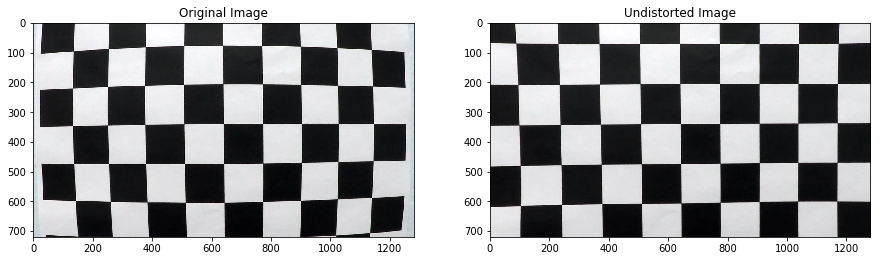

In [6]:
dst = undistortImage(calib_images[0], mtx, dist)  
plotoriginal_vs_processed(calib_images[0], 'Original Image',dst,'Undistorted Image')

In [7]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    gray=cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    abs_sobel = None
    if(orient=='x'):
        abs_sobel=np.absolute(cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=sobel_kernel))
    elif(orient=='y'):
        abs_sobel=np.absolute(cv2.Sobel(gray,cv2.CV_64F,0,1,ksize=sobel_kernel))
    # 3) Take the absolute value of the derivative or gradient
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel=np.uint8((255.0*abs_sobel)/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
    # is > thresh_min and < thresh_max
    #print(np.max(scaled_sobel))
    #print(np.max(abs_sobel))
    binary_output=np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <=thresh[1])]=1
    
    #print(binary_output)
    # Apply threshold
    return binary_output

def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    gray=cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    abs_sobel_x=np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    abs_sobel_y=np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # 3) Calculate the magnitude 
    magnitude=np.sqrt(np.square(abs_sobel_x)+np.square(abs_sobel_y))
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_image=np.uint8(255*magnitude/np.max(magnitude))
    # 5) Create a binary mask where mag thresholds are met
    binary_output=np.zeros_like(scaled_image)
    binary_output[(scaled_image>=mag_thresh[0]) & (scaled_image<=mag_thresh[1])]=1
    return binary_output

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    gray=cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    abs_sobel_x=np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0,  ksize=sobel_kernel))
    abs_sobel_y=np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1,  ksize=sobel_kernel))

    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    absgraddir = np.arctan2(abs_sobel_y, abs_sobel_x)
    # 5) Create a binary mask where mag thresholds are met
    binary_output=np.zeros_like(absgraddir)
    binary_output[(absgraddir>=thresh[0]) & (absgraddir<=thresh[1])]=1
    # Apply threshold
    return binary_output

def hls_select(img, sthresh=(0, 255), lthresh=(0,255)):
    # 1) Convert to HLS color space
    hls=cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel=hls[:,:,2]
    l_channel=hls[:,:,1]
    # 2) Apply a threshold to the S channel
    sbinary_output=np.zeros_like(s_channel)
    # 3) Return a binary image of threshold result
    sbinary_output[(s_channel>sthresh[0]) & (s_channel<=sthresh[1])]=1
    lbinary_output=np.zeros_like(l_channel)
    lbinary_output[(l_channel>lthresh[0]) & (l_channel<=lthresh[1])]=1
    #binary_output = np.copy(img) # placeholder line
    return sbinary_output, lbinary_output

In [8]:
def perspectiveTransform(image):
    #src = np.array([[[225, 700], [600,450], [680,450], [1075,700]]])
    #dst= np.array([[[350,700], [350, 0], [900,0], [900,700]]])
    src = np.float32([[230, 693], [591,450], [689,450], [1076,693]])
    dst= np.float32([[350,700], [350, 0], [900,0], [900,700]])
    M = cv2.getPerspectiveTransform(src, dst)
    Min=cv2.getPerspectiveTransform(dst,src)
    img_size = (image.shape[1], image.shape[0])
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(image, M, img_size)
    return warped, M, Min

In [9]:
def regionOfInterest(image, vertices):
    
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(image, mask)
    return masked_image
    #print(vertices)
    
    #plt.imshow(roiImage, cmap='gray')

In [10]:
def findLines(image):
    histogram = np.sum( image[image.shape[0]//2:,:], axis=0)
    #plt.imshow(warped_single_channel,cmap="gray")
    out_img = np.dstack((image, image, image))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    nwindows = 9
    # Set height of windows
    window_height = np.int(image.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = int(image.shape[0] - (window+1)*window_height)
        win_y_high = int(image.shape[0] - window*window_height)
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 5) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 5) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    ploty = np.linspace(0, image.shape[0]-1, image.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    # out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    # plt.imshow(out_img)
    # plt.plot(left_fitx, ploty, color='yellow')
    # plt.plot(right_fitx, ploty, color='yellow')
    # plt.xlim(0, 1280)
    # plt.ylim(720, 0)
    #print(lefty.shape)
    #print(leftx.shape)
    # findcurvature(ploty, left_fit, right_fit )
    return ploty, left_fit, right_fit, leftx, rightx,lefty, righty, left_fitx, right_fitx
    

In [11]:
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

In [12]:
def findcurvature(ploty, left_fit, right_fit,leftx, rightx, lefty, righty):
    y_eval = np.max(ploty)
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    average_radius_of_curvature=left_curverad+right_curverad/2
    return  average_radius_of_curvature

In [13]:
def findVehicleDistanceFromLaneCenter(image, left_fit, right_fit):
    car_center=image.shape[1]/2
    image_height = image.shape[0] - 1
    left_line = left_fit[0]*(image_height**2) + left_fit[1]*image_height + left_fit[2]
    right_line = right_fit[0]*(image_height**2) + right_fit[1]*image_height + right_fit[2]
    offset = (left_line + right_line)/2 - car_center
    offset *= xm_per_pix  
    return offset
    

In [14]:
def plotLane(image,undistorted, warped, left_fitx, right_fitx, yplot):
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, yplot]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, yplot])))])
    pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Min, (image.shape[1], image.shape[0])) 
# Combine the result with the original image
    result = cv2.addWeighted(undistorted, 1, newwarp, 0.3, 0)
    #plt.imshow(result)
    return result


In [15]:
bottom_left_vertex=(120,720)
top_left_vertex=(500,430)
top_right_vertex=(730,430)
bottom_right_vertex=(1200,720)

vertices=np.array([[bottom_left_vertex, top_left_vertex, top_right_vertex, bottom_right_vertex]])
undistorted_output_path="./output_images/undistorted_test_images/"
color_gradient_output_path="./output_images/color_gradient_images/"
warped_binary_output_path="./output_images/warped_images/"
test_images_path="./test_images/"
file_names = listdir(test_images_path)
rows = len(file_names)
for name in file_names:
    test_image = cv2.imread(test_images_path+name)
    BGRtoRGB = cv2.cvtColor(test_image,cv2.COLOR_BGR2RGB)
    undistorted=undistortImage(BGRtoRGB, mtx, dist)
    
    
    gradx = abs_sobel_thresh(undistorted, orient='x', sobel_kernel=5, thresh=(10, 190))
    grady = abs_sobel_thresh(undistorted, orient='y', sobel_kernel=3, thresh=(20, 180))
    mag_binary = mag_thresh(undistorted, sobel_kernel=3, mag_thresh=(100, 180))
    dir_binary = dir_threshold(undistorted, sobel_kernel=5, thresh=(0.7, 1.2))
    s_binary, l_binary=hls_select(undistorted, sthresh=(200,255),lthresh=(120,255))
    
    combined = np.zeros_like(mag_binary)
    combined[((gradx == 1) | (s_binary == 1)) & (l_binary==1)] = 1
    #combined[( (s_binary == 1) |(l_binary==1))] = 1
    #gradx=np.uint8(gradx*255)
    color_gradient_result=np.dstack(( combined, combined, combined))*255 
    masked_image=regionOfInterest(color_gradient_result, vertices)
    #plotoriginal_vs_processed(undistorted, "Undistorted Image", color_gradient_result, "color and magnitude gradient",src,dst)
    warped_binary, M, Min  = perspectiveTransform(masked_image)
    #cv2.polylines(undistorted,vertices,True,(0,255,0),3)
    #plotoriginal_vs_processed(undistorted, "Undistorted Image", warped_binary, "Perpective transform")
    #cv2.imwrite(undistorted_output_path+name,undistorted)
    #mpimg.imsave(warped_binary_output_path+"undistorted_"+name,warped_binary)
    plt.show()
    warped_single_channel = warped_binary[:,:,0]
    yplot, left_fit, right_fit,leftx, rightx, lefty , righty, left_fitx, right_fitx=findLines(warped_single_channel)
    #findLines(warped_single_channel)
    #left_fit_cr, right_fit_cr,left_curverad, right_curverad=findcurvature(yplot, left_fit, right_fit,leftx, rightx,lefty ,righty )
    offset=findVehicleDistanceFromLaneCenter(warped_single_channel, left_fit, right_fit )
    print(offset)
    plotLane(BGRtoRGB,undistorted, warped_single_channel, left_fitx, right_fitx, yplot)
    

-0.09277060588621021


-0.06143897017146365


0.0375150773333095


0.1721939905576733


0.021717287667485187


0.05072027798255278


-0.051338641631977634


0.029931680169304045


In [25]:
def pipeline(image):
    undistorted=undistortImage(image, mtx, dist)
    gradx = abs_sobel_thresh(undistorted, orient='x', sobel_kernel=15, thresh=(10, 190))
    grady = abs_sobel_thresh(undistorted, orient='y', sobel_kernel=3, thresh=(20, 180))
    mag_binary = mag_thresh(undistorted, sobel_kernel=7, mag_thresh=(110, 180))
    dir_binary = dir_threshold(undistorted, sobel_kernel=5, thresh=(0.7, 1.2))
    s_binary, l_binary=hls_select(undistorted, sthresh=(150,255),lthresh=(120,255))
    R = undistorted[:,:,0]
    R_binary=np.zeros_like(R)
    R_binary[(R>=200) & (R<=255)]=1
    combined = np.zeros_like(mag_binary)
    #combined[((gradx == 1) | (s_binary == 1)) & (l_binary==1)] = 1
    combined[(((s_binary == 1) & (gradx == 1)) | ((gradx == 1) & (R_binary == 1))
                     | ((s_binary == 1) & (R_binary == 1)) |  ((mag_binary == 1) & (dir_binary == 1)) ) & (l_binary==1)] = 1
    color_gradient_result=np.dstack(( combined, combined, combined))*255 
    masked_image=regionOfInterest(color_gradient_result, vertices)
    warped_binary, M, Min  = perspectiveTransform(masked_image)
    warped_single_channel = warped_binary[:,:,0]
    yplot, left_fit, right_fit,leftx, rightx, lefty , righty, left_fitx, right_fitx=findLines(warped_single_channel)
    radius_of_curvature=findcurvature(yplot, left_fit, right_fit,leftx, rightx,lefty ,righty )
    
    offset=findVehicleDistanceFromLaneCenter(warped_single_channel, left_fit, right_fit )
    #result=cv2.addWeighted(undistorted, 1, warped_binary, 0.3, 0)
    
    result=plotLane(BGRtoRGB,undistorted, warped_single_channel, left_fitx, right_fitx, yplot)
    font = cv2.FONT_ITALIC
    if(offset>0):
        cv2.putText(result, "Offset: "+str(round(offset,2)) +" meters to the left of the lane center" , (15,75), font, 1,(255,255,255),2)
    else:
        cv2.putText(result, "Offset: "+str(round(offset,2)) +" meters to the right of the lane center" , (15,75), font, 1,(255,255,255),2)
    cv2.putText(result, "Radius of curvature:" +str(round(radius_of_curvature))+ " meters", (15,150), font, 1,(255,255,255),2)
    return result


In [26]:
from moviepy.editor import VideoFileClip
vid_output = 'test_result.mp4'

# The file referenced in clip1 is the original video before anything has been done to it
clip1 = VideoFileClip("project_video.mp4").subclip('00:00:38.00','00:00:43.00') 
#clip1 = VideoFileClip("project_video.mp4")

# NOTE: this function expects color images
vid_clip = clip1.fl_image(pipeline)
vid_clip.write_videofile(vid_output, audio=False)

[MoviePy] >>>> Building video test_result.mp4


[MoviePy] Writing video test_result.mp4


  0%|                                                                                          | 0/126 [00:00<?, ?it/s]

  1%|▋                                                                                 | 1/126 [00:00<01:48,  1.15it/s]

  2%|█▎                                                                                | 2/126 [00:01<01:38,  1.26it/s]

  2%|█▉                                                                                | 3/126 [00:01<01:26,  1.42it/s]

  3%|██▌                                                                               | 4/126 [00:02<01:14,  1.64it/s]

  4%|███▎                                                                              | 5/126 [00:02<01:07,  1.79it/s]

  5%|███▉                                                                              | 6/126 [00:03<01:01,  1.94it/s]

  6%|████▌                                                                             | 7/126 [00:03<00:56,  2.10it/s]

  6%|█████▏                                                                            | 8/126 [00:04<00:54,  2.16it/s]

  7%|█████▊                                                                            | 9/126 [00:04<00:53,  2.18it/s]

  8%|██████▍                                                                          | 10/126 [00:04<00:51,  2.27it/s]

  9%|███████                                                                          | 11/126 [00:05<00:49,  2.34it/s]

 10%|███████▋                                                                         | 12/126 [00:05<00:47,  2.41it/s]

 10%|████████▎                                                                        | 13/126 [00:06<00:44,  2.55it/s]

 11%|█████████                                                                        | 14/126 [00:06<00:42,  2.65it/s]

 12%|█████████▋                                                                       | 15/126 [00:06<00:39,  2.78it/s]

 13%|██████████▎                                                                      | 16/126 [00:06<00:38,  2.87it/s]

 13%|██████████▉                                                                      | 17/126 [00:07<00:36,  2.96it/s]

 14%|███████████▌                                                                     | 18/126 [00:07<00:35,  3.00it/s]

 15%|████████████▏                                                                    | 19/126 [00:07<00:35,  3.01it/s]

 16%|████████████▊                                                                    | 20/126 [00:08<00:34,  3.08it/s]

 17%|█████████████▌                                                                   | 21/126 [00:08<00:33,  3.11it/s]

 17%|██████████████▏                                                                  | 22/126 [00:08<00:34,  3.02it/s]

 18%|██████████████▊                                                                  | 23/126 [00:09<00:35,  2.91it/s]

 19%|███████████████▍                                                                 | 24/126 [00:09<00:34,  2.99it/s]

 20%|████████████████                                                                 | 25/126 [00:09<00:33,  3.03it/s]

 21%|████████████████▋                                                                | 26/126 [00:10<00:32,  3.08it/s]

 21%|█████████████████▎                                                               | 27/126 [00:10<00:32,  3.08it/s]

 22%|██████████████████                                                               | 28/126 [00:10<00:31,  3.08it/s]

 23%|██████████████████▋                                                              | 29/126 [00:11<00:31,  3.11it/s]

 24%|███████████████████▎                                                             | 30/126 [00:11<00:30,  3.10it/s]

 25%|███████████████████▉                                                             | 31/126 [00:11<00:30,  3.13it/s]

 25%|████████████████████▌                                                            | 32/126 [00:12<00:30,  3.12it/s]

 26%|█████████████████████▏                                                           | 33/126 [00:12<00:29,  3.11it/s]

 27%|█████████████████████▊                                                           | 34/126 [00:12<00:29,  3.12it/s]

 28%|██████████████████████▌                                                          | 35/126 [00:13<00:29,  3.11it/s]

 29%|███████████████████████▏                                                         | 36/126 [00:13<00:28,  3.14it/s]

 29%|███████████████████████▊                                                         | 37/126 [00:13<00:28,  3.13it/s]

 30%|████████████████████████▍                                                        | 38/126 [00:14<00:28,  3.14it/s]

 31%|█████████████████████████                                                        | 39/126 [00:14<00:27,  3.13it/s]

 32%|█████████████████████████▋                                                       | 40/126 [00:14<00:27,  3.11it/s]

 33%|██████████████████████████▎                                                      | 41/126 [00:15<00:27,  3.13it/s]

 33%|███████████████████████████                                                      | 42/126 [00:15<00:26,  3.12it/s]

 34%|███████████████████████████▋                                                     | 43/126 [00:15<00:27,  3.02it/s]

 35%|████████████████████████████▎                                                    | 44/126 [00:16<00:26,  3.04it/s]

 36%|████████████████████████████▉                                                    | 45/126 [00:16<00:26,  3.03it/s]

 37%|█████████████████████████████▌                                                   | 46/126 [00:16<00:26,  3.08it/s]

 37%|██████████████████████████████▏                                                  | 47/126 [00:17<00:25,  3.07it/s]

 38%|██████████████████████████████▊                                                  | 48/126 [00:17<00:25,  3.08it/s]

 39%|███████████████████████████████▌                                                 | 49/126 [00:17<00:25,  3.06it/s]

 40%|████████████████████████████████▏                                                | 50/126 [00:18<00:25,  3.03it/s]

 40%|████████████████████████████████▊                                                | 51/126 [00:18<00:24,  3.05it/s]

 41%|█████████████████████████████████▍                                               | 52/126 [00:18<00:24,  3.06it/s]

 42%|██████████████████████████████████                                               | 53/126 [00:18<00:23,  3.06it/s]

 43%|██████████████████████████████████▋                                              | 54/126 [00:19<00:23,  3.01it/s]

 44%|███████████████████████████████████▎                                             | 55/126 [00:19<00:23,  3.00it/s]

 44%|████████████████████████████████████                                             | 56/126 [00:20<00:23,  3.03it/s]

 45%|████████████████████████████████████▋                                            | 57/126 [00:20<00:22,  3.03it/s]

 46%|█████████████████████████████████████▎                                           | 58/126 [00:20<00:22,  3.05it/s]

 47%|█████████████████████████████████████▉                                           | 59/126 [00:20<00:21,  3.06it/s]

 48%|██████████████████████████████████████▌                                          | 60/126 [00:21<00:21,  3.05it/s]

 48%|███████████████████████████████████████▏                                         | 61/126 [00:21<00:22,  2.94it/s]

 49%|███████████████████████████████████████▊                                         | 62/126 [00:22<00:23,  2.72it/s]

 50%|████████████████████████████████████████▌                                        | 63/126 [00:22<00:22,  2.80it/s]

 51%|█████████████████████████████████████████▏                                       | 64/126 [00:22<00:21,  2.89it/s]

 52%|█████████████████████████████████████████▊                                       | 65/126 [00:23<00:20,  2.93it/s]

 52%|██████████████████████████████████████████▍                                      | 66/126 [00:23<00:20,  2.93it/s]

 53%|███████████████████████████████████████████                                      | 67/126 [00:23<00:19,  3.02it/s]

 54%|███████████████████████████████████████████▋                                     | 68/126 [00:24<00:19,  3.04it/s]

 55%|████████████████████████████████████████████▎                                    | 69/126 [00:24<00:18,  3.06it/s]

 56%|█████████████████████████████████████████████                                    | 70/126 [00:24<00:18,  3.06it/s]

 56%|█████████████████████████████████████████████▋                                   | 71/126 [00:25<00:17,  3.11it/s]

 57%|██████████████████████████████████████████████▎                                  | 72/126 [00:25<00:17,  3.09it/s]

 58%|██████████████████████████████████████████████▉                                  | 73/126 [00:25<00:17,  3.11it/s]

 59%|███████████████████████████████████████████████▌                                 | 74/126 [00:25<00:16,  3.12it/s]

 60%|████████████████████████████████████████████████▏                                | 75/126 [00:26<00:16,  3.14it/s]

 60%|████████████████████████████████████████████████▊                                | 76/126 [00:26<00:16,  3.10it/s]

 61%|█████████████████████████████████████████████████▌                               | 77/126 [00:26<00:15,  3.11it/s]

 62%|██████████████████████████████████████████████████▏                              | 78/126 [00:27<00:15,  3.11it/s]

 63%|██████████████████████████████████████████████████▊                              | 79/126 [00:27<00:15,  3.12it/s]

 63%|███████████████████████████████████████████████████▍                             | 80/126 [00:27<00:14,  3.11it/s]

 64%|████████████████████████████████████████████████████                             | 81/126 [00:28<00:14,  3.14it/s]

 65%|████████████████████████████████████████████████████▋                            | 82/126 [00:28<00:14,  3.13it/s]

 66%|█████████████████████████████████████████████████████▎                           | 83/126 [00:28<00:13,  3.10it/s]

 67%|██████████████████████████████████████████████████████                           | 84/126 [00:29<00:13,  3.12it/s]

 67%|██████████████████████████████████████████████████████▋                          | 85/126 [00:29<00:13,  3.15it/s]

 68%|███████████████████████████████████████████████████████▎                         | 86/126 [00:29<00:12,  3.14it/s]

 69%|███████████████████████████████████████████████████████▉                         | 87/126 [00:30<00:12,  3.12it/s]

 70%|████████████████████████████████████████████████████████▌                        | 88/126 [00:30<00:12,  3.16it/s]

 71%|█████████████████████████████████████████████████████████▏                       | 89/126 [00:30<00:11,  3.13it/s]

 71%|█████████████████████████████████████████████████████████▊                       | 90/126 [00:31<00:11,  3.14it/s]

 72%|██████████████████████████████████████████████████████████▌                      | 91/126 [00:31<00:11,  3.18it/s]

 73%|███████████████████████████████████████████████████████████▏                     | 92/126 [00:31<00:10,  3.21it/s]

 74%|███████████████████████████████████████████████████████████▊                     | 93/126 [00:32<00:10,  3.13it/s]

 75%|████████████████████████████████████████████████████████████▍                    | 94/126 [00:32<00:10,  3.14it/s]

 75%|█████████████████████████████████████████████████████████████                    | 95/126 [00:32<00:09,  3.17it/s]

 76%|█████████████████████████████████████████████████████████████▋                   | 96/126 [00:32<00:09,  3.16it/s]

 77%|██████████████████████████████████████████████████████████████▎                  | 97/126 [00:33<00:09,  3.15it/s]

 78%|███████████████████████████████████████████████████████████████                  | 98/126 [00:33<00:08,  3.18it/s]

 79%|███████████████████████████████████████████████████████████████▋                 | 99/126 [00:33<00:08,  3.18it/s]

 79%|███████████████████████████████████████████████████████████████▍                | 100/126 [00:34<00:08,  3.10it/s]

 80%|████████████████████████████████████████████████████████████████▏               | 101/126 [00:34<00:07,  3.14it/s]

 81%|████████████████████████████████████████████████████████████████▊               | 102/126 [00:34<00:07,  3.16it/s]

 82%|█████████████████████████████████████████████████████████████████▍              | 103/126 [00:35<00:07,  3.12it/s]

 83%|██████████████████████████████████████████████████████████████████              | 104/126 [00:35<00:07,  3.11it/s]

 83%|██████████████████████████████████████████████████████████████████▋             | 105/126 [00:35<00:06,  3.14it/s]

 84%|███████████████████████████████████████████████████████████████████▎            | 106/126 [00:36<00:06,  3.13it/s]

 85%|███████████████████████████████████████████████████████████████████▉            | 107/126 [00:36<00:06,  3.10it/s]

 86%|████████████████████████████████████████████████████████████████████▌           | 108/126 [00:36<00:05,  3.14it/s]

 87%|█████████████████████████████████████████████████████████████████████▏          | 109/126 [00:37<00:05,  3.14it/s]

 87%|█████████████████████████████████████████████████████████████████████▊          | 110/126 [00:37<00:05,  3.11it/s]

 88%|██████████████████████████████████████████████████████████████████████▍         | 111/126 [00:37<00:04,  3.10it/s]

 89%|███████████████████████████████████████████████████████████████████████         | 112/126 [00:38<00:04,  3.13it/s]

 90%|███████████████████████████████████████████████████████████████████████▋        | 113/126 [00:38<00:04,  3.11it/s]

 90%|████████████████████████████████████████████████████████████████████████▍       | 114/126 [00:38<00:03,  3.10it/s]

 91%|█████████████████████████████████████████████████████████████████████████       | 115/126 [00:39<00:03,  3.12it/s]

 92%|█████████████████████████████████████████████████████████████████████████▋      | 116/126 [00:39<00:03,  3.07it/s]

 93%|██████████████████████████████████████████████████████████████████████████▎     | 117/126 [00:39<00:02,  3.00it/s]

 94%|██████████████████████████████████████████████████████████████████████████▉     | 118/126 [00:40<00:03,  2.59it/s]

 94%|███████████████████████████████████████████████████████████████████████████▌    | 119/126 [00:40<00:02,  2.72it/s]

 95%|████████████████████████████████████████████████████████████████████████████▏   | 120/126 [00:40<00:02,  2.81it/s]

 96%|████████████████████████████████████████████████████████████████████████████▊   | 121/126 [00:41<00:01,  2.88it/s]

 97%|█████████████████████████████████████████████████████████████████████████████▍  | 122/126 [00:41<00:01,  2.92it/s]

 98%|██████████████████████████████████████████████████████████████████████████████  | 123/126 [00:41<00:01,  2.93it/s]

 98%|██████████████████████████████████████████████████████████████████████████████▋ | 124/126 [00:42<00:00,  2.95it/s]

 99%|███████████████████████████████████████████████████████████████████████████████▎| 125/126 [00:42<00:00,  2.97it/s]

[MoviePy] Done.


[MoviePy] >>>> Video ready: test_result.mp4 

